# Árbol de decisión con clasificación
El objetivo es contruir un modelo de clasificación medinate Árboles de Decisión usando datos sintéticos.

author: Virginia Ordoño Bernier

date: January 2024

## Notas
Un árbol de decisión es un método de aprendizaje supervisado que puede utilizarse tanto para tareas de clasificación como para regresión. La idea central detrás de un árbol de decisión es dividir iterativamente el conjunto de datos en subconjuntos más pequeños basándose en las características de los datos, con el objetivo de hacer predicciones o tomar decisiones.

### 1. Generación de datos

In [77]:
import numpy as np

# COnfigura el generador de números aleatorios para que genere los mismos números aleatorios cada vez que se ejecute el código.
np.random.seed(41)

# Data: np.random.normal(distribución normal con media, desviación estándar, size=(filas, columnas)). Array bidimensionales
# Labels: array unidimensionales
class_0_data = np.random.normal(0, 1, size=(100, 2))
class_0_labels = np.zeros(100) 

class_1_data = np.random.normal(3, 1, size=(100, 2))
class_1_labels = np.ones(100) 

### 2. Construcción del dataframe

In [78]:
import pandas as pd

X = np.vstack((class_0_data, class_1_data)) # Une dos arrays bidimensionales verticalmente forma un array bidimensional
y = np.concatenate((class_0_labels, class_1_labels)) # Concatena dos arrays unidimensionales en un solo array unidimensional

# Crear un DataFrame con las características y las etiquetas
# Axis = 1: Concatenar a lo largo de las columnas
df_classes = pd.concat([pd.DataFrame(X, columns=['feature_1', 'feature_2']) ,  pd.DataFrame(y, columns=['target'])], axis=1)

# Conversión de datos de la columna target a entero 
df_classes.target = df_classes.target.astype(int)
df_classes.target 

0      0
1      0
2      0
3      0
4      0
      ..
195    1
196    1
197    1
198    1
199    1
Name: target, Length: 200, dtype: int32

### 3. Gráfico de dispersión

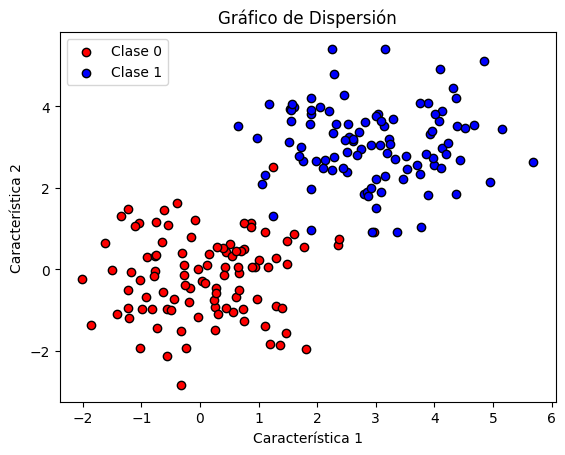

In [79]:
import matplotlib.pyplot as plt

COLORS = ('red', 'blue')

# Iteración con enumerate para obtener el índice y los datos de cada clase
for i, data in enumerate((class_0_data, class_1_data)):
    plt.scatter(data[:, 0], data[:, 1], c=COLORS[i], edgecolor='k', label=f"Clase {i}")

plt.title('Gráfico de Dispersión')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()

plt.show()

### 4. Preparación de los datos para el entrenamiento

In [80]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_classes, test_size=0.33, random_state=42)

# Restablecer los índices. Inplace = True: Modifica el DataFrame original
train.reset_index(inplace = True)
test.reset_index(inplace = True)

print("Conjunto de entrenamiento:")
print(train.head())

print("\nConjunto de prueba:")
print(test.head())

Conjunto de entrenamiento:
   index  feature_1  feature_2  target
0     42  -1.338782   1.320063       0
1    189   0.972373   3.227486       1
2     90  -1.234605   1.470797       0
3    136   2.247596   2.442699       1
4     51  -0.634127  -0.561483       0

Conjunto de prueba:
   index  feature_1  feature_2  target
0     95  -1.205791  -1.190786       0
1     15   1.015425   0.224081       0
2     30   1.803952  -1.948671       0
3    158   3.917554   3.329283       1
4    128   2.928391   0.908526       1


### 5. Validación cruzada: optimización de parámetros

Mayor precisión: 0.97
Mejor profundidad: 1


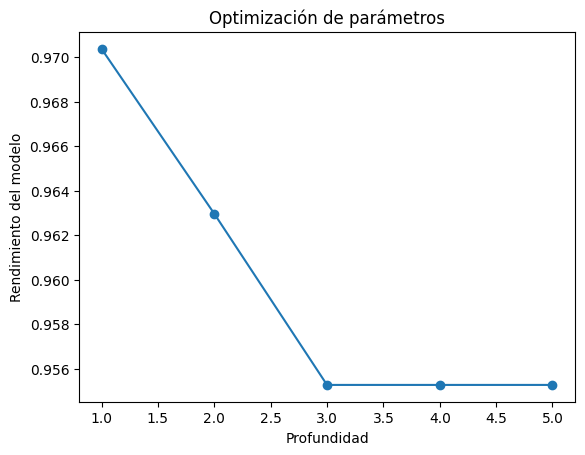

In [81]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# Número de divisiones
SPLITS = 5

# Definir el número de atributos como constante
NUM_ATTRIBUTES = len(list(df_classes))

# Definir el nivel de profundidad del árbol como constante
DEPTH_RANGE = range(1, NUM_ATTRIBUTES * 2)  # Doble del número de atributos del df

# Lista para almacenar las precisiones promedio de cada división/iteración
accuracies = []

# Almacenar la mejor precisión y profundidad
max_accuracy = 0 
best_depth = 0     

# Crea un objeto KFold con divisiones
cv = KFold(n_splits=SPLITS, random_state=42, shuffle=True)

# Iteración sobre diferentes niveles de profundidad
for depth in DEPTH_RANGE:
    fold_accuracy = [] # Almacenar la precisión de cada división/iteración
    
    model = DecisionTreeClassifier(criterion='entropy', max_depth=depth, random_state=42)

    for train_fold, test_fold in cv.split(train):
        f_train = df_classes.loc[train_fold] # Selección de filas para el grupo de entrenamiento
        f_test = df_classes.loc[test_fold] # Selección de filas para el grupo de prueba

        # Ajuste del modelo
        model.fit(X=f_train.drop(['target'], axis=1), y=f_train['target'])
        
        # Predicción del modelo
        y_pred = model.predict(X=f_test.drop(['target'], axis=1))
        
        # Evaluación del modelo
        avg_accuracy = accuracy_score(f_test['target'], y_pred)
        
        # Almacenar la precisión de cada división/iteración
        fold_accuracy.append(avg_accuracy)
        
    # Añadir el promedio de precisión a la lista
    avg_accuracy_depth = sum(fold_accuracy) / len(fold_accuracy)
    accuracies.append(avg_accuracy_depth)

    # Actualizar las variables de la mejor precisión y profundidad
    if avg_accuracy_depth > max_accuracy:
        max_accuracy = avg_accuracy_depth
        best_depth = depth

plt.plot(DEPTH_RANGE, accuracies, marker='o')
plt.xlabel('Profundidad')
plt.ylabel('Rendimiento del modelo')
plt.title('Optimización de parámetros')

print(f"Mayor precisión: {max_accuracy:.2f}")
print(f"Mejor profundidad: {best_depth}")
plt.show()


### 6. Creación del modelo con los mejores hiperparámetros

In [82]:
from sklearn.metrics import classification_report

X_train = train.drop(['target', 'index'], axis=1)
y_train = train['target']

X_test = test.drop(['target', 'index'], axis=1)
y_test = test['target']

# Construcción del modelo con la mejor profundidad
model = DecisionTreeClassifier(max_depth = best_depth)
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

# Información de la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"La precisión del modelo es: {accuracy:.2f}")

print("\nInforme de Clasificación")
print(classification_report(y_test, y_pred)) 

La precisión del modelo es: 0.94

Informe de Clasificación
              precision    recall  f1-score   support

           0       0.92      0.97      0.94        35
           1       0.97      0.90      0.93        31

    accuracy                           0.94        66
   macro avg       0.94      0.94      0.94        66
weighted avg       0.94      0.94      0.94        66



### 7. Visualizacion del árbol de decisión

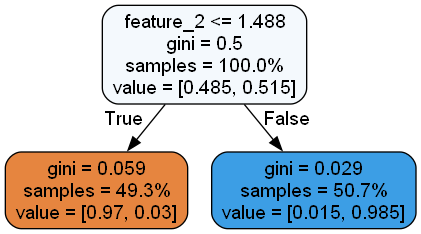

In [83]:
import pydot
from IPython.display import Image
from io import StringIO
from sklearn import tree

# Crear un archivo .dot con la información del árbol
dot_data = StringIO()

# Obtener los nombres de las columnas menos la última y convertirlos a lista
columns_names = df_classes.columns[:-1].tolist()

# Exportar el árbol a un archivo .dot
# proportion = True: muestra samples en porcentaje en lugar de número de muestras
tree.export_graphviz(model, out_file = dot_data, proportion = True, feature_names = columns_names, rounded = True, filled = True)

# Crear el gráfico del árbol
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

### 8. Visualización de la importancia de las variables
Cada característica contribuye a reducir la impureza (o aumentar la pureza) de los nodos en el árbol de decisión durante el proceso de entrenamiento. Las variables con mayor importancia tienen más impacto a la hora de hacer la predición.

Informe de Importancia de las Variables:
     Feature  Importance
1  feature_2         1.0
0  feature_1         0.0


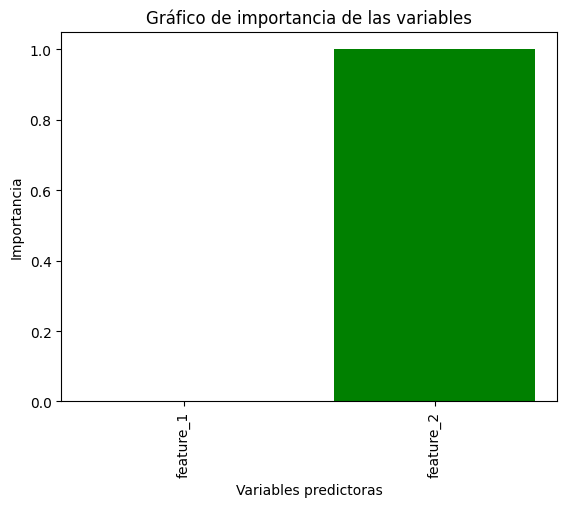

In [88]:
importances = model.feature_importances_

# Create dataframe
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

# Order by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Informe de Importancia de las Variables:")
print(feature_importance_df)

# Gráfico de importancia de las variables
feature_names = df_classes.columns[:-1]
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.bar(feature_names, importances, color=colors)
plt.xticks(rotation=90)
plt.xlabel('Variables predictoras')
plt.ylabel('Importancia')
plt.title('Gráfico de importancia de las variables')
plt.show()
